In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
!pip install timm

In [4]:
!pip install -Uqq git+https://github.com/butchland/fastai_xla_extensions.git

In [5]:
!pip install -Uqq cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp37-cp37m-linux_x86_64.whl

In [6]:
import fastai_xla_extensions.core

/opt/conda/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [7]:
import torch
from torch import nn
from fastai.vision.learner import cnn_learner, create_head, create_body, num_features_model, default_split, has_pool_type, apply_init, _update_first_layer

In [8]:
#from fastai.vision.transform import get_transforms
from fastai.metrics import error_rate
from pathlib import Path
from fastai.vision.all import *
import torch_xla

In [9]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [10]:
!ls /kaggle/input/

d


In [11]:
data_dir = '/kaggle/input/d/dhiadah/car-data-train'
path=Path(data_dir)
path

Path('/kaggle/input/d/dhiadah/car-data-train')

In [12]:
batch_tfms = [*aug_transforms(size=128, max_warp=0), Normalize.from_stats(*imagenet_stats)]
item_tfms = RandomResizedCrop(500, min_scale=0.8)

data = ImageDataLoaders.from_folder(path, bs=64, valid_pct=0.2, batch_tfms=batch_tfms,
                                  item_tfms=item_tfms, method=ResizeMethod.Squish, num_workers=4)

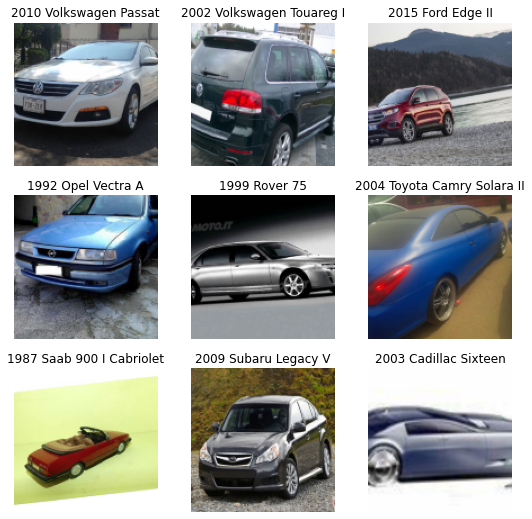

In [13]:
data.show_batch()

In [14]:
from timm import create_model

def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")
        
body = create_timm_body('resnext101_32x8d', pretrained=True)


In [15]:
nf = num_features_model(nn.Sequential(*body.children())); nf
head = create_head(nf, data.c)


In [16]:
data.c

4041

In [17]:
model = nn.Sequential(body, head)

In [18]:
apply_init(model[1], nn.init.kaiming_normal_)

In [19]:
learn = Learner(data, model, loss_func=LabelSmoothingCrossEntropy(), 
                splitter=default_split, metrics=error_rate, model_dir="/tmp")

In [20]:
learn.freeze()
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 64 x 64   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 256 x 32 x 32  
Conv2d                                    16384      False     
BatchNorm2d                               512        True      
ReLU                                                           
Conv2d                                    18432      False     
BatchNorm2d                               512        True      
Identity                                                       
ReLU                                                           
Identity                                  

In [ ]:
learn.lr_find()

In [ ]:
pip install gdown

In [ ]:
!gdown https://drive.google.com/uc?id=1Tb5q9EYjDsgXosLwajEmc31HhSz0gjkU

In [ ]:
learn.load('/kaggle/working/cmodel')

In [ ]:
learn.fit(12, 2e-4)

Unfreezing, fine-tuning, and learning rates

In [ ]:
import requests
img = requests.get('https://pictures.topspeed.com/IMG/crop/201203/2012-geneva-motor-sh-3_800x0w.jpg')
learn.predict(img.content)


In [ ]:
learn.export('/kaggle/working/model.pkl')

In [ ]:
from IPython.display import FileLink 
FileLink(r'cmodel.pth')